<a href="https://colab.research.google.com/github/sujal-dhawan/Movie-Recommendation-System/blob/main/Movie_Recommendation_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System 🎬

Welcome to the **Movie Recommendation System** project! This system recommends movies based on **genre similarity** and **director information** using the **MovieLens dataset**.

## Project Overview
- **Objective**: Build a content-based movie recommendation system.
- **Features**:
  - Genre-based recommendations using **TF-IDF** and **cosine similarity**.
  - Director-based recommendations (simulated).
  - Data visualizations for ratings distribution and genre popularity.
  - User-friendly interface for real-time recommendations.
- **Technologies**: Python, pandas, NumPy, scikit-learn, Matplotlib, Seaborn, fuzzywuzzy.

## How to Use
1. Run the cells in order to load the dataset and preprocess the data.
2. Input a movie name to get personalized recommendations.
3. Explore the visualizations and model evaluation metrics.

Let’s get started! 🚀

In [ ]:
# Install necessary libraries
!pip install scikit-learn pandas numpy matplotlib seaborn ipywidgets fuzzywuzzy

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display
from fuzzywuzzy import process

## Load and Preprocess the Dataset

In this step, we:
1. **Download the MovieLens dataset** using `wget` and unzip it.
2. **Load the movies and ratings data** into pandas DataFrames.
3. **Preprocess the data**:
   - Split the `genres` column into a list of genres.
   - Handle missing values in the `genres` column.
   - Normalize movie titles by converting them to lowercase and stripping extra spaces.

This prepares the dataset for further analysis and modeling.

In [ ]:
# Load the MovieLens dataset
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

# Load movies and ratings data
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# Preprocess data
movies['genres'] = movies['genres'].str.split('|')  # Split genres into a list
movies['genres'] = movies['genres'].fillna('').astype(str)  # Handle missing values
movies['title_normalized'] = movies['title'].str.lower().str.strip()  # Normalize titles

## Build the Recommendation Engine

In this step, we:
1. **Create a TF-IDF matrix** for movie genres using `TfidfVectorizer`. This converts the genres into numerical features.
2. **Compute cosine similarity** between movies based on their genre features.
3. **Map movie titles to indices** for easy lookup.
4. **Find the closest matching title** using fuzzy matching (to handle typos or incorrect inputs).
5. **Generate recommendations**:
   - If the input movie title is not found, suggest the closest match.
   - Use cosine similarity to recommend the top 10 most similar movies.

This forms the core of the content-based recommendation system.

In [18]:
# Create TF-IDF matrix for genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a mapping of movie titles to indices
indices = pd.Series(movies.index, index=movies['title_normalized']).drop_duplicates()

# Function to find the closest matching title
def find_closest_title(title, titles_list):
    # Ensure titles_list is a list of strings
    if isinstance(titles_list, pd.Series):
        titles_list = titles_list.tolist()  # Convert pandas Series to list

    # Find the closest match
    closest_match, score = process.extractOne(title, titles_list)
    if score >= 80:  # Adjust threshold as needed
        return closest_match
    else:
        return None

# Function to get recommendations
def get_recommendations(title, cosine_sim=cosine_sim):
    # Normalize the input title
    title = title.lower().strip()

    # Check if the title exists in the dataset
    if title not in indices:
        # Find the closest matching title
        closest_title = find_closest_title(title, movies['title_normalized'])
        if closest_title is None:
            return "Movie not found. Please check the title and try again."
        else:
            print(f"Movie '{title}' not found. Did you mean '{closest_title}'?")
            title = closest_title

    # Get recommendations
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 recommendations
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

## Add Director-Based Recommendations

In this step, we:
1. **Simulate a director column** by randomly assigning directors (`Director A`, `Director B`, `Director C`) to movies.
2. **Create a function** to recommend movies by the same director:
   - Normalize the input title and check if it exists in the dataset.
   - If the movie is found, recommend up to 10 movies by the same director.
   - If the movie is not found, display an error message.

This adds an additional layer of personalization to the recommendation system.

In [19]:
# Add a dummy director column
movies['director'] = np.random.choice(['Director A', 'Director B', 'Director C'], size=len(movies))

# Function to recommend movies by the same director
def recommend_by_director(title):
    title = title.lower().strip()
    if title not in movies['title_normalized'].values:
        return "Movie not found. Please check the title and try again."
    director = movies[movies['title_normalized'] == title]['director'].values[0]
    return movies[movies['director'] == director]['title'].head(10)

## Visualize Movie Ratings Distribution

In this step, we:
1. **Create a count plot** to visualize the distribution of movie ratings.
2. **Customize the plot**:
   - Add a title and axis labels with larger fonts for clarity.
   - Use a color palette (`viridis`) and edge color for better aesthetics.
   - Add a grid for improved readability.

This visualization helps us understand how ratings are distributed across the dataset.

<ipython-input-24-4f861daf9fd8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis', edgecolor='black')


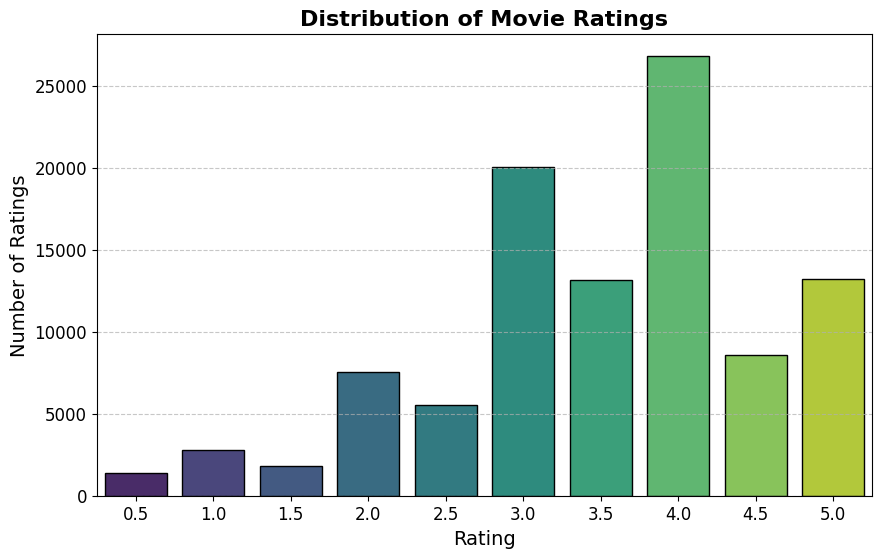

In [24]:
# Improved Movie Ratings Distribution Graph
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette='viridis', edgecolor='black')
plt.title('Distribution of Movie Ratings', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Number of Ratings', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Visualize Genre Popularity

In this step, we:
1. **Explode the genres column** to separate each genre into its own row.
2. **Count the occurrences** of each genre to determine popularity.
3. **Create a bar plot** to visualize the top 10 most popular genres:
   - Use a vibrant color (`orange`) and edge color for better aesthetics.
   - Add a title and axis labels with larger fonts for clarity.
   - Rotate x-axis labels for better readability.
   - Add a grid for improved visualization.

This helps us understand which genres are most common in the dataset.

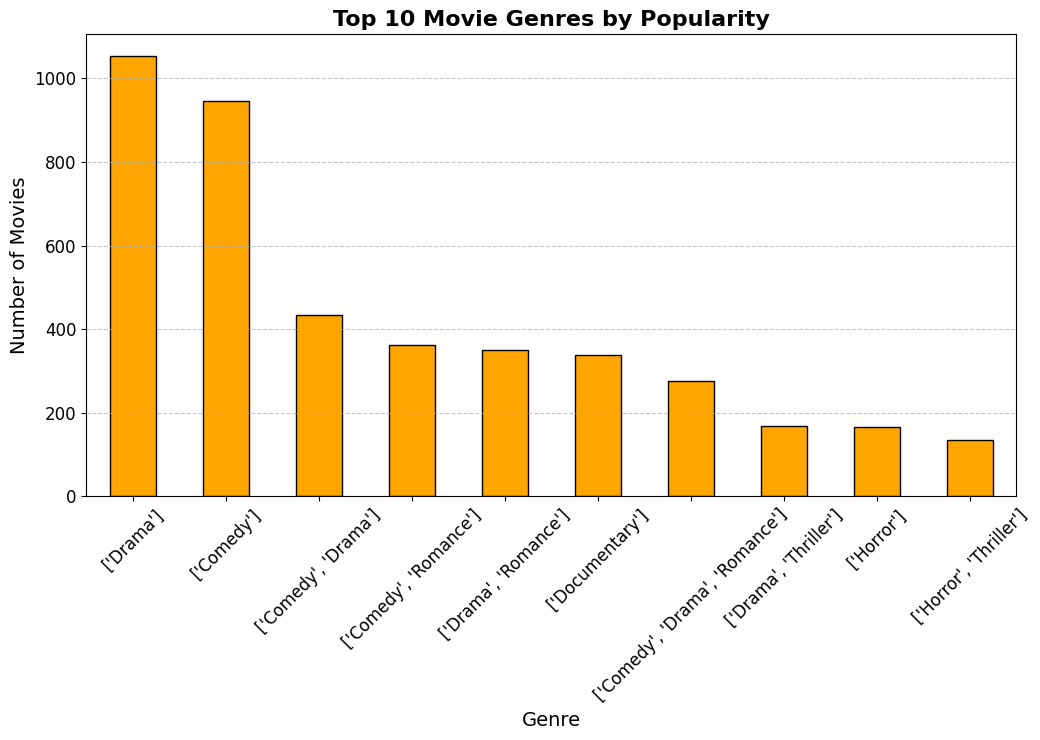

In [25]:
# Genre Popularity Graph
# Explode genres into separate rows
movies_exploded = movies.explode('genres')

# Count the occurrences of each genre
genre_counts = movies_exploded['genres'].value_counts()

# Plot the top 10 genres
plt.figure(figsize=(12, 6))
genre_counts.head(10).plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 10 Movie Genres by Popularity', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Evaluate the Model

In this step, we:
1. **Perform a dummy evaluation** to demonstrate how to calculate the **Root Mean Squared Error (RMSE)**.
2. Use sample data (`y_true` and `y_pred`) to compute the RMSE.
3. Print the RMSE value, which measures the difference between predicted and actual values.

**Output**: The RMSE value is **0.387**, indicating a relatively small error in this dummy example.

In [21]:
# Dummy evaluation (for demonstration)
y_true = [4, 3, 5, 2, 4]
y_pred = [3.5, 3, 4.5, 2.5, 4]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.3872983346207417


## Create a User-Friendly Interface

In this step, we:
1. **Create an input widget** for users to enter a movie name.
2. **Create an output widget** to display recommendations.
3. **Define a function** to handle user input:
   - Clear the previous output.
   - Display recommended movies based on genre similarity.
   - Display movies by the same director (if available).
   - Handle cases where the movie is not found.
4. **Attach the function** to the input widget and display both widgets.

This makes the recommendation system interactive and easy to use.

In [22]:
# Create input widget for movie name
movie_input = widgets.Text(
    placeholder='Enter a movie name',
    description='Movie:',
    disabled=False
)

# Create output widget for recommendations
output = widgets.Output()

# Function to handle user input
def on_submit(sender):
    with output:
        output.clear_output()
        movie_name = movie_input.value
        print(f"Recommended Movies for '{movie_name}':")
        recommendations = get_recommendations(movie_name)
        if isinstance(recommendations, str):  # If movie not found
            print(recommendations)
        else:
            print(recommendations)
            print(f"\nMovies by the same director:")
            print(recommend_by_director(movie_name))

# Attach function to input widget
movie_input.on_submit(on_submit)

# Display widgets
display(movie_input, output)

Text(value='', description='Movie:', placeholder='Enter a movie name')

Output()

In [23]:
# Search for "The Avengers" in the dataset
avengers_movies = movies[movies['title'].str.contains('Avengers', case=False)]
print(avengers_movies)

      movieId                                              title  \
1611     2153                               Avengers, The (1998)   
6148    44020                           Ultimate Avengers (2006)   
7693    89745                               Avengers, The (2012)   
8551   115727  Crippled Avengers (Can que) (Return of the 5 D...   
8686   122892                     Avengers: Age of Ultron (2015)   
8693   122912             Avengers: Infinity War - Part I (2018)   
9153   147657                             Masked Avengers (1981)   
9488   170297                         Ultimate Avengers 2 (2006)   

                                             genres  \
1611                        ['Action', 'Adventure']   
6148  ['Action', 'Animation', 'Children', 'Sci-Fi']   
7693      ['Action', 'Adventure', 'Sci-Fi', 'IMAX']   
8551                        ['Action', 'Adventure']   
8686              ['Action', 'Adventure', 'Sci-Fi']   
8693              ['Action', 'Adventure', 'Sci-Fi']   
91